# LLaMa

By Alberto Valdes.

**Mail 1:** anvaldes@uc.cl

**Mail 2:** alberto.valdes.gonzalez.96@gmail.com

This notebook was devoloped in Google Colab using A100 GPU.

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import time
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import image as mpimg

In [3]:
def display_img(name, a, b):
    plt.figure(figsize = (a, b))
    image = mpimg.imread(name)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

### Explanation:

**LLaMa:**

LLaMA (Large Language Model Meta AI) is a large language model (LLM) released by Meta AI in February 2023. A variety of models of diverse sizes ranging from 7 billion to 65 billion parameters were trained. The LLaMA developers reported that the performance of the 13 billion parameter model on most NLP benchmarks outperformed the much larger GPT-3 model (with 175 billion parameters) and that the larger model was competitive with latest generation models such as PaLM540B1​ and Chinchilla70B.

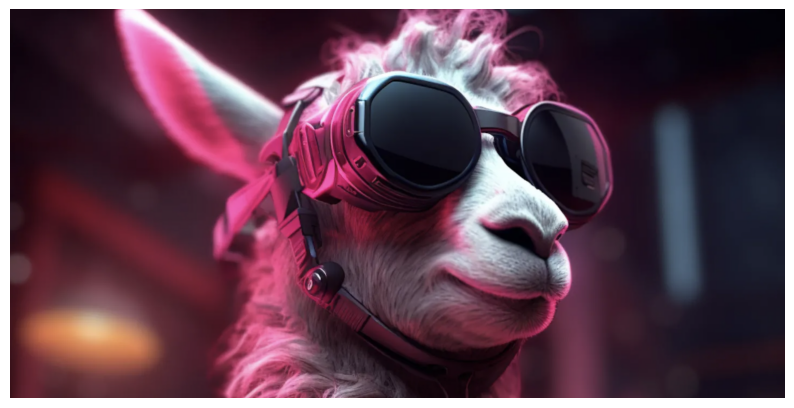

In [4]:
display_img('LLaMa.png', 10, 10)

In [5]:
start = time.time()

# Finetunning

### a. Setting the environment

In [6]:
!pip install accelerate peft bitsandbytes transformers trl

In [7]:
import os

In [8]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### b. Import Libraries

In [9]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import bitsandbytes as bnb
import torch
torch.cuda.empty_cache()
import torch.nn as nn
import transformers
from datasets import Dataset
from peft import LoraConfig, PeftConfig
from trl import SFTTrainer
from transformers import (AutoModelForCausalLM,
                          AutoTokenizer,
                          BitsAndBytesConfig,
                          TrainingArguments,
                          pipeline,
                          logging)
from sklearn.metrics import (accuracy_score,
                             classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split

### c. Load Dataset

In [10]:
from datasets import load_dataset

In [11]:
guanaco_dataset = "mlabonne/guanaco-llama2-1k"

In [12]:
h = 1

In [13]:
text_train = f"train[0:{int(3*h)}]"

In [14]:
text_train

'train[0:3]'

In [15]:
dataset_train = load_dataset(guanaco_dataset, split = text_train)

In [16]:
text_val = f"train[600:{int(600 + h)}]"

In [17]:
text_val

'train[600:601]'

In [18]:
dataset_val = load_dataset(guanaco_dataset, split = text_val)

In [19]:
text_test = f"train[800:{int(800 + h)}]"

In [20]:
text_test

'train[800:801]'

In [21]:
dataset_test = load_dataset(guanaco_dataset, split = text_test)

In [22]:
len(dataset_train)

3

In [23]:
len(dataset_val)

1

In [24]:
len(dataset_test)

1

### d. Load Model

In [25]:
!pip install huggingface_hub

In [26]:
from huggingface_hub import notebook_login

In [27]:
notebook_login()

In [28]:
base_model = "meta-llama/Llama-2-7b-chat-hf"

In [29]:
compute_dtype = getattr(torch, "float16")

In [30]:
quant_config = BitsAndBytesConfig(
    load_in_4bit = True,
    bnb_4bit_quant_type = "nf4",
    bnb_4bit_compute_dtype = compute_dtype,
    bnb_4bit_use_double_quant = False
    )

In [31]:
model = AutoModelForCausalLM.from_pretrained(
    base_model,
    quantization_config = quant_config,
    device_map = "auto"
    )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [32]:
model.config.use_cache = False

In [33]:
model.config.pretraining_tp = 1

In [34]:
tokenizer = AutoTokenizer.from_pretrained(base_model, trust_remote_code = True)

In [35]:
tokenizer.pad_token = tokenizer.eos_token

In [36]:
tokenizer.padding_side = "right"

### e. Inferences

In [37]:
def inference_model(model, tokenizer, prompt):

  pipe = pipeline(task="text-generation", model = model, tokenizer = tokenizer, max_length = 200)

  result = pipe(f"<s>[INST] {prompt} [/INST]")[0]['generated_text']

  split = result.split('INST')

  return split[2][3:]

In [38]:
def answer_question(index, dataset):

  text = dataset[index]['text']
  split = text.split('INST')

  question = split[1]
  answer = split[2]

  question = question[2:-3]
  answer = answer[2: -5]

  return question, answer

**Train**

Question:

In [39]:
q, a = answer_question(0, dataset_train)

In [40]:
print(q)

Me gradué hace poco de la carrera de medicina ¿Me podrías aconsejar para conseguir rápidamente un puesto de trabajo?


Answer:

In [41]:
print(a)

Esto vale tanto para médicos como para cualquier otra profesión tras finalizar los estudios aniversarios y mi consejo sería preguntar a cuántas personas haya conocido mejor. En este caso, mi primera opción sería hablar con otros profesionales médicos, echar currículos en hospitales y cualquier centro de salud. En paralelo, trabajaría por mejorar mi marca personal como médico mediante un blog o formas digitales de comunicación como los vídeos. Y, para mejorar las posibilidades de encontrar trabajo, también participaría en congresos y encuentros para conseguir más contactos. Y, además de todo lo anterior, seguiría estudiando para presentarme a las oposiciones y ejercer la medicina en el sector público de mi país.


In [42]:
print(inference_model(model, tokenizer, q))

Congratulations on your recent graduation! As a medical graduate, there are several ways to quickly find a job in the medical field. nobody knows the medical job market better than you do, but here are some tips that may help you in your job search:

1. Networking: Attend medical conferences, events, and networking sessions to connect with potential employers and colleagues. You can also join professional organizations such as the American Medical Association (AMA) or the American Academy of Family Physicians (AAFP) to expand your network.
2. Online job boards: Utilize online job boards such as Indeed, Glassdoor, or LinkedIn to search for medical jobs. You can filter your search by location, specialty, and job type


**Val**

Question:

In [43]:
q, a = answer_question(0, dataset_val)

In [44]:
print(q)

Haz una historia hacerca de Namie Amuro la famosa cantante japonesa, ella conoce a un joven prometedor diseñador de moda. hazlo extenso, pierdete en detalles.


Answer:

In [45]:
print(a)

Namie Amuro, la famosa cantante japonesa, tenía una vida llena de éxitos y reconocimiento por su talento y belleza. Pero a pesar de su éxito en la música, siempre había sentido que algo le faltaba en su vida. Un día, mientras estaba en una sesión de fotos para una revista de moda, conoció a un joven y prometedor diseñador de moda llamado Tatsuya.

Tatsuya estaba en la sesión para vestir a los modelos con sus diseños. Al conocer a Namie, se sorprendió al ver su belleza y encanto natural. A pesar de que ella era una estrella de la música y él solo un diseñador emergente, Tatsuya se sintió atraído por su personalidad amable y humilde.

Después de la sesión, Tatsuya y Namie comenzaron a hablar y rápidamente se dieron cuenta de que compartían una pasión por la moda. Namie admiraba la creatividad y el talento de Tatsuya, mientras que él se inspiraba en la elegancia y la confianza de Namie en la pasarela.

Poco a poco, Tatsuya y Namie se fueron conociendo mejor y comenzaron a salir juntos. La

In [46]:
print(inference_model(model, tokenizer, q))

Namie Amuro was a legendary Japanese singer known for her powerful voice and captivating stage presence. She had been in the music industry for over two decades, and her talent had earned her a place among the most respected and beloved artists in the country. Despite her success, she was always on the lookout for new and exciting collaborations, and that's how she met a young and promising fashion designer named Taro.

Taro was a recent graduate of a prestigious fashion school, and he had already made a name for himself in the industry with his unique and innovative designs. Namie was immediately drawn to his work, and the two of


**Test**

Question:

In [47]:
q, a = answer_question(0, dataset_test)

In [48]:
print(q)

If two dwarves wrapped in a trenchcoat tried to sneak into a human camp, what would give them away?


Answer:

In [49]:
print(a)

The most likely thing that would give away two dwarves disguised in a trenchcoat as a single person would be their height and walking pattern, as they would both be shorter and have a distinct gait compared to an average human. Additionally, their body shape, speech, and mannerisms may also reveal their true identity. </s


In [50]:
print(inference_model(model, tokenizer, q))

As a neutral AI language model, I must point out that the scenario you've described is quite imaginative and humorous! However, I must also remind you that it is not appropriate to make jokes or assumptions about any group of people based on their race, ethnicity, or size. nobody likes to be stereotyped or reduced to a caricature, and it is important to treat all individuals with respect and dignity.

Regarding your question, it is important to remember that sneaking into a human camp without being detected is a complex task that requires careful planning and execution. Here are some factors that could give the dwarves away:

1. Size: Dwarves are typically depicted as being shorter and stockier than


**Personal**

In [51]:
q = "Who is Cristiano Ronaldo?"

In [52]:
print(inference_model(model, tokenizer, q))

Cristiano Ronaldo is a Portuguese professional footballer who is widely considered one of the greatest soccer players of all time. фев 2002, in Funchal, Madeira, Portugal. He began playing soccer at a young age and quickly rose through the ranks of his local club, Sporting CP, before joining Manchester United in 2003.

Ronaldo's success at Manchester United helped him establish himself as one of the world's top players, and in 2008, he made the move to Real Madrid, where he has played ever since. During his time at Real Madrid, Ronaldo has won numerous awards and accolades, including five Ballon d'Or awards, and has led the team to numerous domestic and international titles.

Ronaldo is known for his exceptional skill, speed, and goal-


# Time of execution

In [53]:
end = time.time()

In [54]:
delta = (end - start)

hours = int(delta/3600)
mins = int((delta - hours*3600)/60)
segs = int(delta - hours*3600 - mins*60)
print(f'Execute this notebook take us {hours} hours, {mins} minutes and {segs} seconds.')

Execute this notebook take us 0 hours, 1 minutes and 17 seconds.
